# In the last notebooks the best parameters for the datasets (base period, training period) were found, for some models, and for the prediction of 1, 7, 14, 28 and 56 days ahead. Two models were finally considered: Linear Regression and Random Forest. In this notebook the hyperparameters will be tuned for the Random Forest, and the best model will be chosen for each "ahead day" (1, 7, 14, 28, 56).

In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')
import utils.misc as misc

Populating the interactive namespace from numpy and matplotlib


## Let's first organize the results from the previous notebooks

In [2]:
res_df = pd.read_pickle('../../data/results_ahead1_linear_df.pkl')

In [3]:
res_df.head()

,base_days,ahead_days,train_val_time,step_days,GOOD_DATA_RATIO,SAMPLES_GOOD_DATA_RATIO,x_filename,y_filename,train_days,scores,r2,mre
0,7,1,-1,7,0.99,0.9,x_base7_ahead1.pkl,y_base7_ahead1.pkl,252,"(0.834741188062, 0.0153118291225)",0.834741,0.015312
1,14,1,-1,7,0.99,0.9,x_base14_ahead1.pkl,y_base14_ahead1.pkl,252,"(0.900241572634, 0.0167286326766)",0.900242,0.016729
2,28,1,-1,7,0.99,0.9,x_base28_ahead1.pkl,y_base28_ahead1.pkl,252,"(0.952896891193, 0.015095253567)",0.952897,0.015095
3,56,1,-1,7,0.99,0.9,x_base56_ahead1.pkl,y_base56_ahead1.pkl,252,"(0.974173264084, 0.0156013450074)",0.974173,0.015601
4,112,1,-1,7,0.99,0.9,x_base112_ahead1.pkl,y_base112_ahead1.pkl,252,"(0.985143962052, 0.0170847165167)",0.985144,0.017085


In [4]:
RELEVANT_COLUMNS = ['base_days', 
                    'train_days', 
                    'r2',
                    'mre',
                    'ahead_days',
                    'train_val_time',
                    'step_days',
                    'GOOD_DATA_RATIO',
                    'SAMPLES_GOOD_DATA_RATIO',
                    'x_filename',
                    'y_filename']

best_params_df = res_df[RELEVANT_COLUMNS].loc[np.argmin(res_df['mre']),:]
best_params_df['model'] = 'linear'
best_params_df

base_days                                   14
train_days                                 504
r2                                    0.924353
mre                                  0.0145049
ahead_days                                   1
train_val_time                              -1
step_days                                    7
GOOD_DATA_RATIO                           0.99
SAMPLES_GOOD_DATA_RATIO                    0.9
x_filename                 x_base14_ahead1.pkl
y_filename                 y_base14_ahead1.pkl
model                                   linear
Name: 6, dtype: object

In [5]:
test_df = pd.DataFrame()
test_df.append(best_params_df, ignore_index=True)

,GOOD_DATA_RATIO,SAMPLES_GOOD_DATA_RATIO,ahead_days,base_days,model,mre,r2,step_days,train_days,train_val_time,x_filename,y_filename
0,0.99,0.9,1.0,14.0,linear,0.014505,0.924353,7.0,504.0,-1.0,x_base14_ahead1.pkl,y_base14_ahead1.pkl


In [6]:
RELEVANT_COLUMNS = ['base_days', 
                    'train_days', 
                    'r2',
                    'mre',
                    'ahead_days',
                    'train_val_time',
                    'step_days',
                    'GOOD_DATA_RATIO',
                    'SAMPLES_GOOD_DATA_RATIO',
                    'x_filename',
                    'y_filename']

ahead_days_list = [1, 7, 14, 28, 56]
models_list = ['linear', 'random_forest']

results_df = pd.DataFrame()
for ahead_days in ahead_days_list:
    for model in models_list:
        res_df = pd.read_pickle('../../data/results_ahead{}_{}_df.pkl'.format(ahead_days, model))
        best_params_df = res_df[RELEVANT_COLUMNS].loc[np.argmax(res_df['r2']),:]
        best_params_df['ahead_days'] = ahead_days
        best_params_df['model'] = model
        results_df = results_df.append(best_params_df, ignore_index=True)

In [7]:
results_df

,GOOD_DATA_RATIO,SAMPLES_GOOD_DATA_RATIO,ahead_days,base_days,model,mre,r2,step_days,train_days,train_val_time,x_filename,y_filename
0,0.99,0.9,1.0,112.0,linear,0.015856,0.986599,7.0,504.0,-1.0,x_base112_ahead1.pkl,y_base112_ahead1.pkl
1,0.99,0.9,1.0,112.0,random_forest,0.018002,0.984864,7.0,756.0,-1.0,x_base112_ahead1.pkl,y_base112_ahead1.pkl
2,0.99,0.9,7.0,112.0,linear,0.042367,0.923348,7.0,756.0,-1.0,x_base112_ahead7.pkl,y_base112_ahead7.pkl
3,0.99,0.9,7.0,112.0,random_forest,0.044267,0.915048,7.0,756.0,-1.0,x_base112_ahead7.pkl,y_base112_ahead7.pkl
4,0.99,0.9,14.0,112.0,linear,0.060167,0.865259,7.0,756.0,-1.0,x_base112_ahead14.pkl,y_base112_ahead14.pkl
5,0.99,0.9,14.0,112.0,random_forest,0.063327,0.829452,7.0,756.0,-1.0,x_base112_ahead14.pkl,y_base112_ahead14.pkl
6,0.99,0.9,28.0,112.0,linear,0.091966,0.758046,7.0,756.0,-1.0,x_base112_ahead28.pkl,y_base112_ahead28.pkl
7,0.99,0.9,28.0,112.0,random_forest,0.096087,0.715802,7.0,756.0,-1.0,x_base112_ahead28.pkl,y_base112_ahead28.pkl
8,0.99,0.9,56.0,112.0,linear,0.127913,0.590426,7.0,756.0,-1.0,x_base112_ahead56.pkl,y_base112_ahead56.pkl
9,0.99,0.9,56.0,112.0,random_forest,0.136095,0.512861,7.0,756.0,-1.0,x_base112_ahead56.pkl,y_base112_ahead56.pkl


In [8]:
results_df.to_pickle('../../data/best_dataset_params_raw_df.pkl')

Which is the best model before hyperparameter tuning?

In [9]:
def keep_max_r2(record):
    return record.loc[np.argmax(record['r2']),:]

best_r2_df = results_df.groupby('ahead_days').apply(keep_max_r2)
best_r2_df

,GOOD_DATA_RATIO,SAMPLES_GOOD_DATA_RATIO,ahead_days,base_days,model,mre,r2,step_days,train_days,train_val_time,x_filename,y_filename
ahead_days,,,,,,,,,,,,
1.0,0.99,0.9,1.0,112.0,linear,0.015856,0.986599,7.0,504.0,-1.0,x_base112_ahead1.pkl,y_base112_ahead1.pkl
7.0,0.99,0.9,7.0,112.0,linear,0.042367,0.923348,7.0,756.0,-1.0,x_base112_ahead7.pkl,y_base112_ahead7.pkl
14.0,0.99,0.9,14.0,112.0,linear,0.060167,0.865259,7.0,756.0,-1.0,x_base112_ahead14.pkl,y_base112_ahead14.pkl
28.0,0.99,0.9,28.0,112.0,linear,0.091966,0.758046,7.0,756.0,-1.0,x_base112_ahead28.pkl,y_base112_ahead28.pkl
56.0,0.99,0.9,56.0,112.0,linear,0.127913,0.590426,7.0,756.0,-1.0,x_base112_ahead56.pkl,y_base112_ahead56.pkl


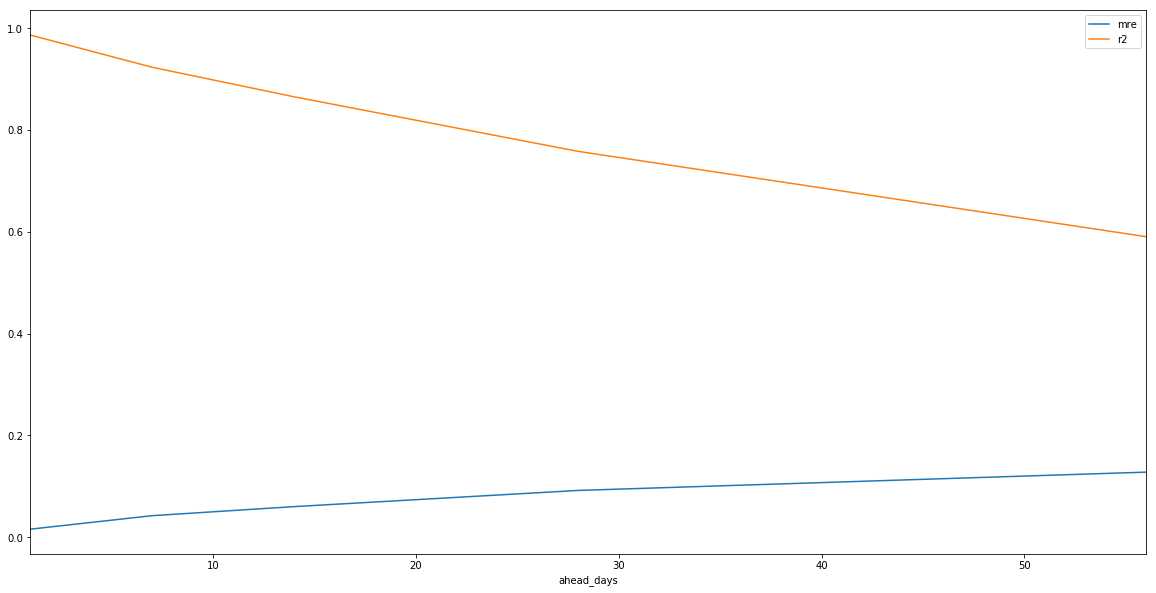

In [10]:
best_r2_df[['mre', 'r2']].plot()

Before hyperparameter tuning, it seems like the linear regression is doing better in all the predictions. Clearly, as the days ahead are more, the r2 value drops, and the mre goes up.

## Let's search for better hyperparameters for the Random Forest models

In [11]:
initial_performance_df = results_df[results_df['model']=='random_forest']
initial_performance_df.set_index('ahead_days', inplace=True)
initial_performance_df

,GOOD_DATA_RATIO,SAMPLES_GOOD_DATA_RATIO,base_days,model,mre,r2,step_days,train_days,train_val_time,x_filename,y_filename
ahead_days,,,,,,,,,,,
1.0,0.99,0.9,112.0,random_forest,0.018002,0.984864,7.0,756.0,-1.0,x_base112_ahead1.pkl,y_base112_ahead1.pkl
7.0,0.99,0.9,112.0,random_forest,0.044267,0.915048,7.0,756.0,-1.0,x_base112_ahead7.pkl,y_base112_ahead7.pkl
14.0,0.99,0.9,112.0,random_forest,0.063327,0.829452,7.0,756.0,-1.0,x_base112_ahead14.pkl,y_base112_ahead14.pkl
28.0,0.99,0.9,112.0,random_forest,0.096087,0.715802,7.0,756.0,-1.0,x_base112_ahead28.pkl,y_base112_ahead28.pkl
56.0,0.99,0.9,112.0,random_forest,0.136095,0.512861,7.0,756.0,-1.0,x_base112_ahead56.pkl,y_base112_ahead56.pkl


In [12]:
initial_performance_df.loc[14, 'base_days']

112.0

## Build the hyperparameters DataFrame

In [13]:
n_estimators = [50, 100]
max_depth = [5, 10]
hyper_df = pd.DataFrame([(x, y) for x in n_estimators for y in max_depth], columns=['n_estimators', 'max_depth'])
hyper_df['n_jobs'] = -1
hyper_df

,n_estimators,max_depth,n_jobs
0,50,5,-1
1,50,10,-1
2,100,5,-1
3,100,10,-1


In [14]:
params_df = initial_performance_df.loc[1]
params_df

GOOD_DATA_RATIO                            0.99
SAMPLES_GOOD_DATA_RATIO                     0.9
base_days                                   112
model                             random_forest
mre                                   0.0180017
r2                                     0.984864
step_days                                     7
train_days                                  756
train_val_time                               -1
x_filename                 x_base112_ahead1.pkl
y_filename                 y_base112_ahead1.pkl
Name: 1.0, dtype: object

## Ahead days = 1

Evaluating: {'n_estimators': 100, 'max_depth': 10, 'n_jobs': -1}
Evaluating: {'n_estimators': 50, 'max_depth': 10, 'n_jobs': -1}
Evaluating: {'n_estimators': 100, 'max_depth': 5, 'n_jobs': -1}
Generating: base112_ahead1_train756
Evaluating: {'n_estimators': 50, 'max_depth': 5, 'n_jobs': -1}
Generating: base112_ahead1_train756
Generating: base112_ahead1_train756
Generating: base112_ahead1_train756
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Approximately 101.3 percent complete.    (0.98381408302069029, 0.019143977213481194)
Approximately 90.9 percent complete.     (0.98418220377123244, 0.019091244957495992)
Approximately 72.7 percent complete.     (0.98612570882134876, 0.016850455554563416)
Approximately 101.3 percent complete.    (0.98606697491007356, 0.016820250789550569)
Minimum MRE param set: 
 n_estimators       

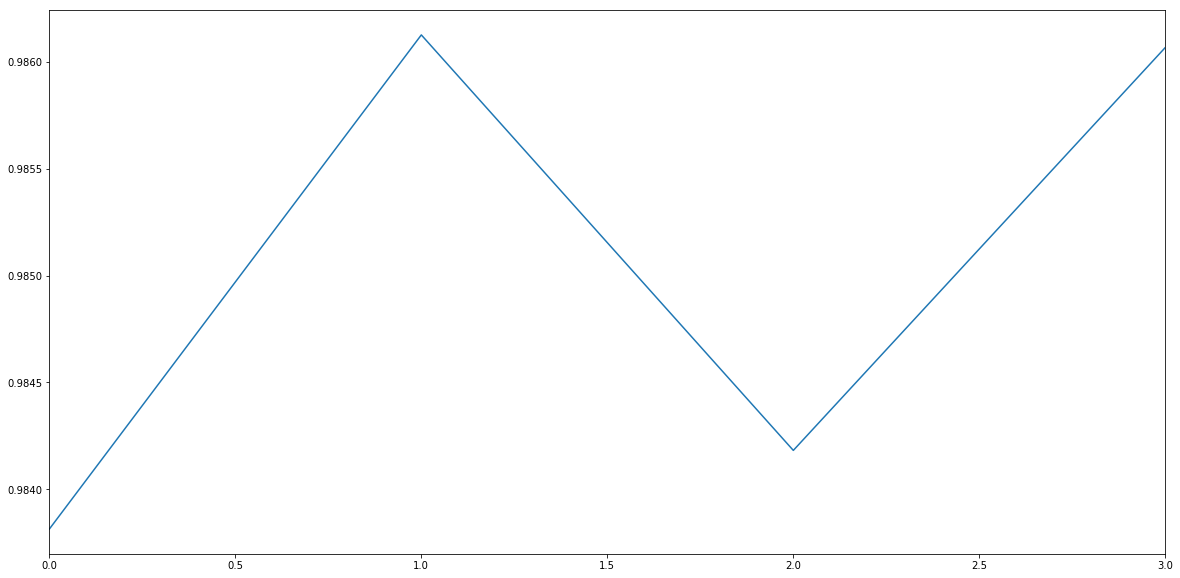

In [15]:
AHEAD_DAYS = 1

# Get the normal parameters set
params_df = initial_performance_df.loc[AHEAD_DAYS].copy()
params_df['ahead_days'] = AHEAD_DAYS

tic = time()

from predictor.random_forest_predictor import RandomForestPredictor
PREDICTOR_NAME = 'random_forest'

# Global variables
eval_predictor_class = RandomForestPredictor
step_eval_days = 60  # The step to move between training/validation pairs

# Build the params list
params = {'params_df': params_df,
          'step_eval_days': step_eval_days,
          'eval_predictor_class': eval_predictor_class}

results_df = misc.parallelize_dataframe(hyper_df, misc.search_mean_score_eval, params)

# Some postprocessing... -----------------------------------------------------------
results_df['r2'] = results_df.apply(lambda x: x['scores'][0], axis=1)
results_df['mre'] = results_df.apply(lambda x: x['scores'][1], axis=1)
# Pickle that!
results_df.to_pickle('../../data/hyper_ahead{}_{}_df.pkl'.format(AHEAD_DAYS, PREDICTOR_NAME))
results_df['r2'].plot()

print('Minimum MRE param set: \n {}'.format(results_df.iloc[np.argmin(results_df['mre'])]))
print('Maximum R^2 param set: \n {}'.format(results_df.iloc[np.argmax(results_df['r2'])]))
# -----------------------------------------------------------------------------------

toc = time()
print('Elapsed time: {} seconds.'.format((toc-tic)))

## Ahead days = 7

Evaluating: {'n_estimators': 100, 'max_depth': 5, 'n_jobs': -1}
Evaluating: {'n_estimators': 50, 'max_depth': 5, 'n_jobs': -1}
Evaluating: {'n_estimators': 50, 'max_depth': 10, 'n_jobs': -1}
Evaluating: {'n_estimators': 100, 'max_depth': 10, 'n_jobs': -1}
Generating: base112_ahead7_train756
Generating: base112_ahead7_train756
Generating: base112_ahead7_train756
Generating: base112_ahead7_train756
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Approximately 101.3 percent complete.    (0.92867427413659043, 0.042073389045121791)
Approximately 101.3 percent complete.    (0.92901657711577335, 0.042002474848861167)
Approximately 101.3 percent complete.    (0.92530656870090644, 0.041440316788257971)
Approximately 101.3 percent complete.    (0.92659030746215731, 0.041326296086241686)
Minimum MRE param set: 
 n_estimators       

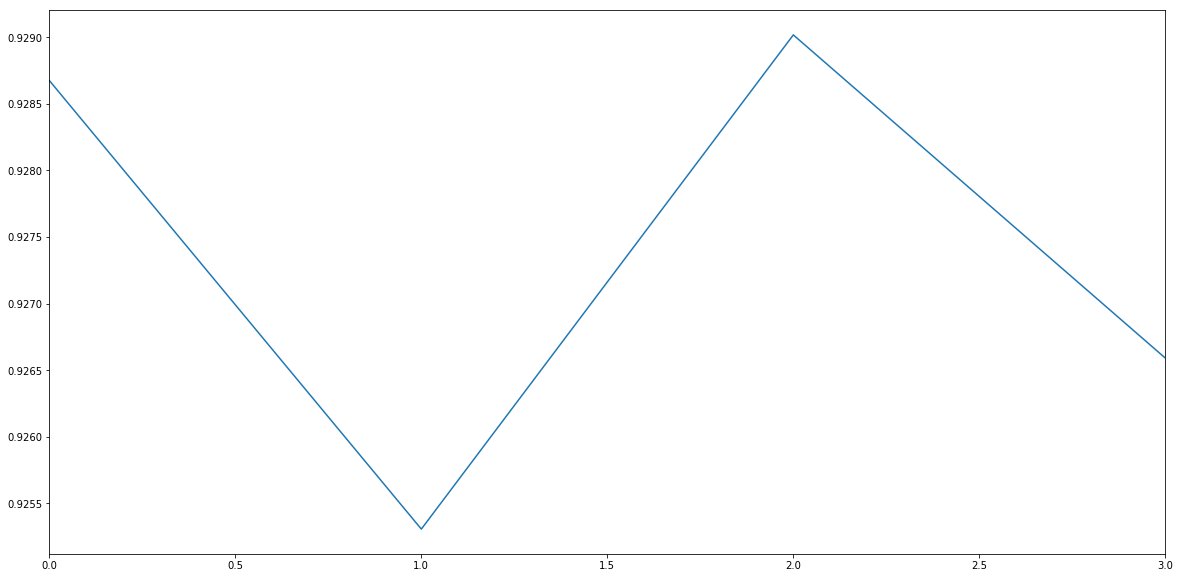

In [16]:
AHEAD_DAYS = 7

# Get the normal parameters set
params_df = initial_performance_df.loc[AHEAD_DAYS].copy()
params_df['ahead_days'] = AHEAD_DAYS

tic = time()

from predictor.random_forest_predictor import RandomForestPredictor
PREDICTOR_NAME = 'random_forest'

# Global variables
eval_predictor_class = RandomForestPredictor
step_eval_days = 60  # The step to move between training/validation pairs

# Build the params list
params = {'params_df': params_df,
          'step_eval_days': step_eval_days,
          'eval_predictor_class': eval_predictor_class}

results_df = misc.parallelize_dataframe(hyper_df, misc.search_mean_score_eval, params)

# Some postprocessing... -----------------------------------------------------------
results_df['r2'] = results_df.apply(lambda x: x['scores'][0], axis=1)
results_df['mre'] = results_df.apply(lambda x: x['scores'][1], axis=1)
# Pickle that!
results_df.to_pickle('../../data/hyper_ahead{}_{}_df.pkl'.format(AHEAD_DAYS, PREDICTOR_NAME))
results_df['r2'].plot()

print('Minimum MRE param set: \n {}'.format(results_df.iloc[np.argmin(results_df['mre'])]))
print('Maximum R^2 param set: \n {}'.format(results_df.iloc[np.argmax(results_df['r2'])]))
# -----------------------------------------------------------------------------------

toc = time()
print('Elapsed time: {} seconds.'.format((toc-tic)))

## Ahead days = 14

Evaluating: {'n_estimators': 100, 'max_depth': 5, 'n_jobs': -1}
Evaluating: {'n_estimators': 50, 'max_depth': 5, 'n_jobs': -1}
Evaluating: {'n_estimators': 100, 'max_depth': 10, 'n_jobs': -1}
Evaluating: {'n_estimators': 50, 'max_depth': 10, 'n_jobs': -1}
Generating: base112_ahead14_train756
Generating: base112_ahead14_train756
Generating: base112_ahead14_train756
Generating: base112_ahead14_train756
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Approximately 70.1 percent complete.     (0.86854483835222773, 0.059552721522095425)
Approximately 93.5 percent complete.     (0.86892702579234082, 0.059514978873294676)
Approximately 101.3 percent complete.    (0.85556550478037119, 0.059458013790502723)
Approximately 101.3 percent complete.    (0.86161618765643722, 0.05932458230969568)
Minimum MRE param set: 
 n_estimators    

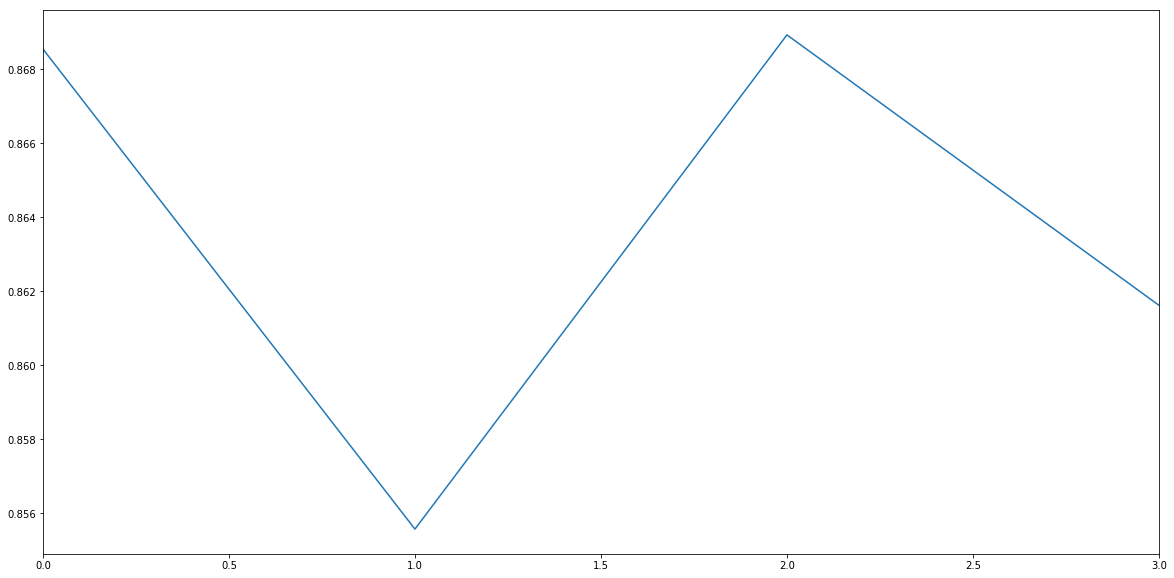

In [17]:
AHEAD_DAYS = 14

# Get the normal parameters set
params_df = initial_performance_df.loc[AHEAD_DAYS].copy()
params_df['ahead_days'] = AHEAD_DAYS

tic = time()

from predictor.random_forest_predictor import RandomForestPredictor
PREDICTOR_NAME = 'random_forest'

# Global variables
eval_predictor_class = RandomForestPredictor
step_eval_days = 60  # The step to move between training/validation pairs

# Build the params list
params = {'params_df': params_df,
          'step_eval_days': step_eval_days,
          'eval_predictor_class': eval_predictor_class}

results_df = misc.parallelize_dataframe(hyper_df, misc.search_mean_score_eval, params)

# Some postprocessing... -----------------------------------------------------------
results_df['r2'] = results_df.apply(lambda x: x['scores'][0], axis=1)
results_df['mre'] = results_df.apply(lambda x: x['scores'][1], axis=1)
# Pickle that!
results_df.to_pickle('../../data/hyper_ahead{}_{}_df.pkl'.format(AHEAD_DAYS, PREDICTOR_NAME))
results_df['r2'].plot()

print('Minimum MRE param set: \n {}'.format(results_df.iloc[np.argmin(results_df['mre'])]))
print('Maximum R^2 param set: \n {}'.format(results_df.iloc[np.argmax(results_df['r2'])]))
# -----------------------------------------------------------------------------------

toc = time()
print('Elapsed time: {} seconds.'.format((toc-tic)))

## Ahead days = 28

Evaluating: {'n_estimators': 50, 'max_depth': 5, 'n_jobs': -1}
Evaluating: {'n_estimators': 100, 'max_depth': 5, 'n_jobs': -1}
Generating: base112_ahead28_train756
Evaluating: {'n_estimators': 50, 'max_depth': 10, 'n_jobs': -1}
Generating: base112_ahead28_train756
Evaluating: {'n_estimators': 100, 'max_depth': 10, 'n_jobs': -1}
Generating: base112_ahead28_train756
Generating: base112_ahead28_train756
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Evaluating approximately 77 training/evaluation pairs
Approximately 100.0 percent complete.    (0.76511197091963712, 0.090310449239112411)
Approximately 100.0 percent complete.    (0.76483623247521459, 0.090362126076648244)
Approximately 100.0 percent complete.    (0.75795817643584429, 0.090145606122285907)
Approximately 100.0 percent complete.    (0.75846744620443518, 0.090220889159736098)
Minimum MRE param set: 
 n_estimators   

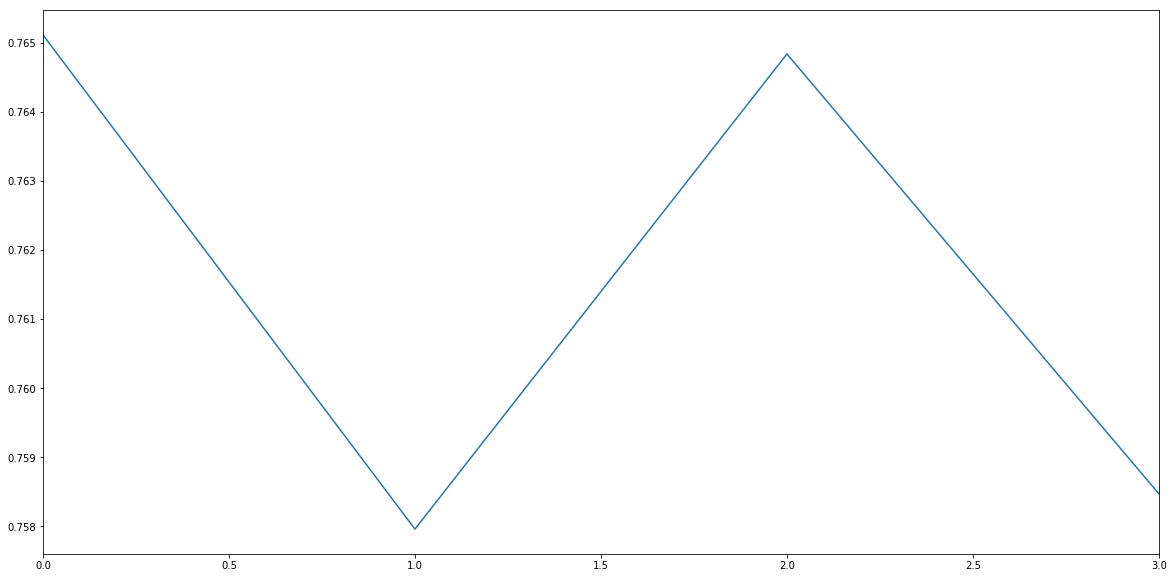

In [18]:
AHEAD_DAYS = 28

# Get the normal parameters set
params_df = initial_performance_df.loc[AHEAD_DAYS].copy()
params_df['ahead_days'] = AHEAD_DAYS

tic = time()

from predictor.random_forest_predictor import RandomForestPredictor
PREDICTOR_NAME = 'random_forest'

# Global variables
eval_predictor_class = RandomForestPredictor
step_eval_days = 60  # The step to move between training/validation pairs

# Build the params list
params = {'params_df': params_df,
          'step_eval_days': step_eval_days,
          'eval_predictor_class': eval_predictor_class}

results_df = misc.parallelize_dataframe(hyper_df, misc.search_mean_score_eval, params)

# Some postprocessing... -----------------------------------------------------------
results_df['r2'] = results_df.apply(lambda x: x['scores'][0], axis=1)
results_df['mre'] = results_df.apply(lambda x: x['scores'][1], axis=1)
# Pickle that!
results_df.to_pickle('../../data/hyper_ahead{}_{}_df.pkl'.format(AHEAD_DAYS, PREDICTOR_NAME))
results_df['r2'].plot()

print('Minimum MRE param set: \n {}'.format(results_df.iloc[np.argmin(results_df['mre'])]))
print('Maximum R^2 param set: \n {}'.format(results_df.iloc[np.argmax(results_df['r2'])]))
# -----------------------------------------------------------------------------------

toc = time()
print('Elapsed time: {} seconds.'.format((toc-tic)))

## Ahead days = 56

Evaluating: {'n_estimators': 50, 'max_depth': 5, 'n_jobs': -1}
Evaluating: {'n_estimators': 100, 'max_depth': 5, 'n_jobs': -1}
Evaluating: {'n_estimators': 50, 'max_depth': 10, 'n_jobs': -1}
Evaluating: {'n_estimators': 100, 'max_depth': 10, 'n_jobs': -1}
Generating: base112_ahead56_train756
Generating: base112_ahead56_train756
Generating: base112_ahead56_train756
Generating: base112_ahead56_train756
Evaluating approximately 76 training/evaluation pairs
Evaluating approximately 76 training/evaluation pairs
Evaluating approximately 76 training/evaluation pairs
Evaluating approximately 76 training/evaluation pairs
Approximately 101.3 percent complete.    (0.61541202680466478, 0.12640953814082068)
Approximately 101.3 percent complete.    (0.61381359078137865, 0.12647375426109192)
Approximately 101.3 percent complete.    (0.59592620102113891, 0.12788679297679451)
Approximately 101.3 percent complete.    (0.60070055912489662, 0.12775455708581532)
Minimum MRE param set: 
 n_estimators       

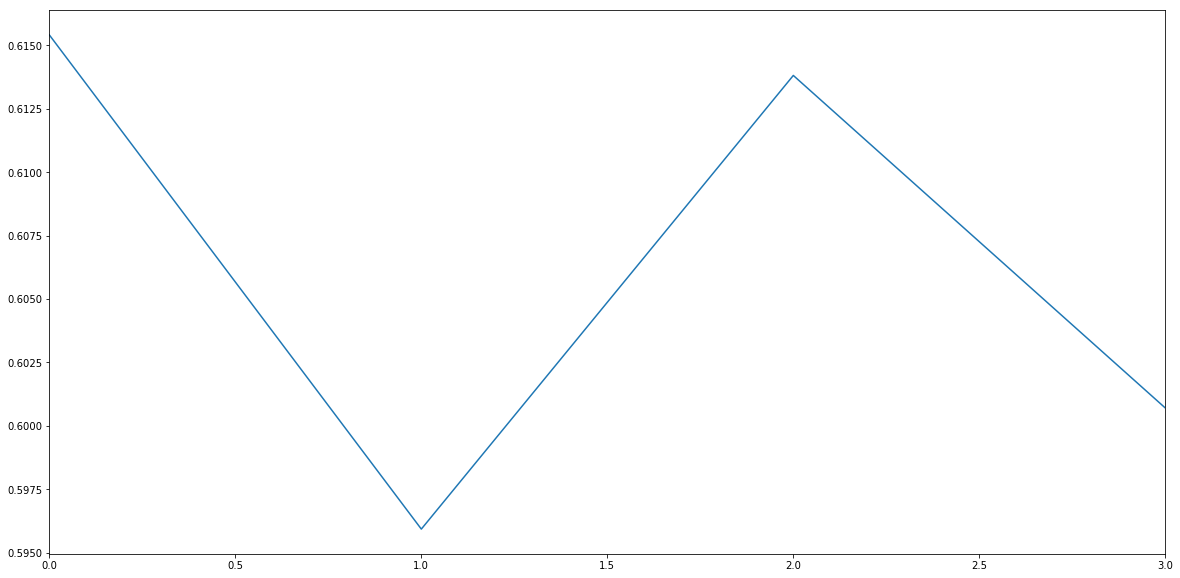

In [19]:
AHEAD_DAYS = 56

# Get the normal parameters set
params_df = initial_performance_df.loc[AHEAD_DAYS].copy()
params_df['ahead_days'] = AHEAD_DAYS

tic = time()

from predictor.random_forest_predictor import RandomForestPredictor
PREDICTOR_NAME = 'random_forest'

# Global variables
eval_predictor_class = RandomForestPredictor
step_eval_days = 60  # The step to move between training/validation pairs

# Build the params list
params = {'params_df': params_df,
          'step_eval_days': step_eval_days,
          'eval_predictor_class': eval_predictor_class}

results_df = misc.parallelize_dataframe(hyper_df, misc.search_mean_score_eval, params)

# Some postprocessing... -----------------------------------------------------------
results_df['r2'] = results_df.apply(lambda x: x['scores'][0], axis=1)
results_df['mre'] = results_df.apply(lambda x: x['scores'][1], axis=1)
# Pickle that!
results_df.to_pickle('../../data/hyper_ahead{}_{}_df.pkl'.format(AHEAD_DAYS, PREDICTOR_NAME))
results_df['r2'].plot()

print('Minimum MRE param set: \n {}'.format(results_df.iloc[np.argmin(results_df['mre'])]))
print('Maximum R^2 param set: \n {}'.format(results_df.iloc[np.argmax(results_df['r2'])]))
# -----------------------------------------------------------------------------------

toc = time()
print('Elapsed time: {} seconds.'.format((toc-tic)))